In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import curve_fit

In [2]:
df=pd.read_csv('sample_data_MV_biased_test.csv')
poro=df['Porosity']
poro=np.asarray(poro)

In [3]:
cat=[1,0]

poro_cat=np.where(poro>0.15, cat[0], cat[1])

pk1=np.sum(poro_cat==1)/len(poro_cat)
pk0=1-pk1

pk1,pk0

(0.23097826086956522, 0.7690217391304348)

In [4]:
#Probabilities of each categories at known points (hard data)

P0,P1=[],[]
for i in range(0,len(poro_cat)):
    P0=np.append(P0,np.where(poro_cat[i]==0,1,0))
    P1=np.append(P1,np.where(poro_cat[i]==1,1,0))

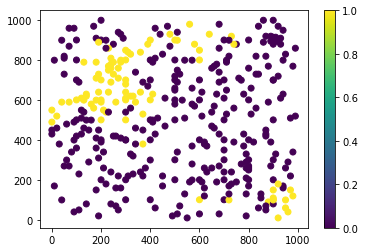

In [5]:
X=df['X']
Y=df['Y']
plt.scatter(X,Y,c=poro_cat)
plt.colorbar()

In [6]:
# Declustering

length_x=1000
length_y=1000
grid_dim_x=10
grid_dim_y=10
Nx=length_x/grid_dim_x
Ny=length_y/grid_dim_y
ix=np.ceil(X/grid_dim_x)
iy=np.ceil(Y/grid_dim_y)
ix[ix==0]=1
iy[iy==0]=1

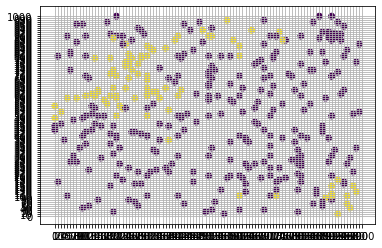

In [7]:
# Plotting the grid

tick_label=np.arange(0,length_x+grid_dim_x,grid_dim_x)
plt.scatter(X,Y,c=poro_cat)
plt.xticks(tick_label)
plt.yticks(tick_label) 
plt.grid()

In [8]:
#Grid location 

loc=(iy-1)*Nx+ix

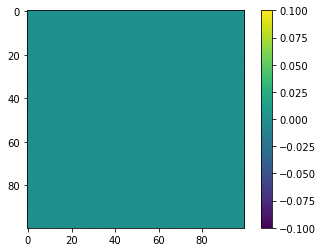

In [9]:
# Visualization of the grid

poro_grid0=np.zeros([int(Nx),int(Ny)])
poro_grid1=np.zeros([int(Nx),int(Ny)]) # Initializing a grid to store the new values
plt.imshow(poro_grid0)
plt.colorbar()

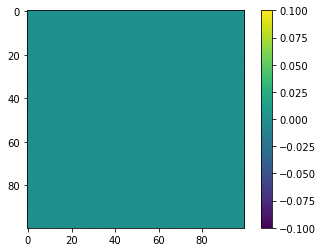

In [10]:
# Initializing a variance grid

var_grid=np.zeros([int(Nx),int(Ny)])
plt.imshow(var_grid)
plt.colorbar()

In [11]:
X=np.asmatrix(X).T
Y=np.asmatrix(Y).T
ix=np.asmatrix(ix).T
iy=np.asmatrix(iy).T
loc=np.asmatrix(loc).T
poro_cat=np.asmatrix(poro_cat).T
n_points = poro.shape[0]

P0=np.matrix(P0).T
P1=np.matrix(P1).T

In [12]:
ones_vec = np.asmatrix(np.ones(n_points))
X_mat = X*ones_vec
Y_mat = Y*ones_vec
poro_mat = poro_cat*ones_vec
dist = np.sqrt(np.power(X_mat-X_mat.T,2)+np.power(Y_mat-Y_mat.T,2))
sq_diff= np.power(poro_mat-poro_mat.T,2)

P0_mat = P0*ones_vec
P1_mat = P1*ones_vec
sq_diff0= np.power(P0_mat-P0_mat.T,2)
sq_diff1= np.power(P1_mat-P1_mat.T,2)

In [13]:
# Fot Cat. 0

lag_size=10
n_lags=100 
lag_tol=0.5*lag_size
EDVar0=np.zeros(n_lags) 

Azimuth=45
angle_tol=20
bandwidth=100
ual=Azimuth+angle_tol 
lal=Azimuth-angle_tol 

for l in range (1,n_lags):
    # Computing lag distances 
    lag=l+1 
    ul=lag_size*lag+lag_tol # Upper lag
    ll=lag_size*lag-lag_tol # Lower lag
    index=np.argwhere((dist<=ul)&(dist>=ll))
    
    # Computing points angles and comparisson with azimuth
    points_angle=np.arctan(np.divide(X[index[:,0]],Y[index[:,0]]))*180/np.pi
    angle_id= np.argwhere((points_angle<=ual)&(points_angle>=lal)) 
    points_af_ang=points_angle[angle_id[:,0]]
    
    # Comparison with bandwidth
    index_af_ang=index[angle_id[:,0],:]
    diff_ang=np.abs(Azimuth-points_af_ang) 
    Hyp=(np.sqrt(np.power(X[index_af_ang[:,0]],2)+np.power(Y[index_af_ang[:,0]],2)))
    dp_with_dv=np.multiply(Hyp,np.sin(diff_ang*np.pi/180))
    id_af_bw=np.argwhere(dp_with_dv<=bandwidth)
    
    index_af_bw=index_af_ang[id_af_bw[:,0],:] 
    
    Nh=index_af_bw.shape[0] # Gives me the number of pairs
    EDVar0[l]=np.sum(sq_diff0[index_af_bw[:,0],index_af_bw[:,1]])/(2*Nh)

In [14]:
# Fot Cat. 1

lag_size=10
n_lags=100 
lag_tol=0.5*lag_size
EDVar1=np.zeros(n_lags) 

Azimuth=45
angle_tol=20
bandwidth=100
ual=Azimuth+angle_tol 
lal=Azimuth-angle_tol 

for l in range (1,n_lags):
    # Computing lag distances 
    lag=l+1 
    ul=lag_size*lag+lag_tol # Upper lag
    ll=lag_size*lag-lag_tol # Lower lag
    index=np.argwhere((dist<=ul)&(dist>=ll))
    
    # Computing points angles and comparisson with azimuth
    points_angle=np.arctan(np.divide(X[index[:,0]],Y[index[:,0]]))*180/np.pi
    angle_id= np.argwhere((points_angle<=ual)&(points_angle>=lal)) 
    points_af_ang=points_angle[angle_id[:,0]]
    
    # Comparison with bandwidth
    index_af_ang=index[angle_id[:,0],:]
    diff_ang=np.abs(Azimuth-points_af_ang) 
    Hyp=(np.sqrt(np.power(X[index_af_ang[:,0]],2)+np.power(Y[index_af_ang[:,0]],2)))
    dp_with_dv=np.multiply(Hyp,np.sin(diff_ang*np.pi/180))
    id_af_bw=np.argwhere(dp_with_dv<=bandwidth)
    
    index_af_bw=index_af_ang[id_af_bw[:,0],:] 
    
    Nh=index_af_bw.shape[0] # Gives me the number of pairs
    EDVar1[l]=np.sum(sq_diff1[index_af_bw[:,0],index_af_bw[:,1]])/(2*Nh)

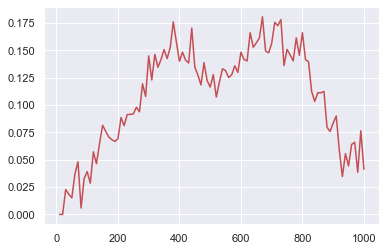

In [15]:
lag_dist=np.arange(lag_size,lag_size*(n_lags+1),lag_size)
sns.set()
plt.plot(lag_dist,EDVar0,'r')

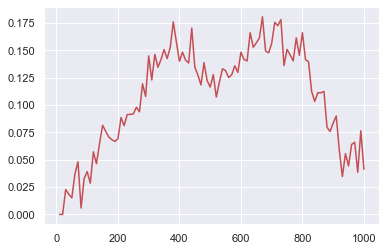

In [16]:
lag_dist=np.arange(lag_size,lag_size*(n_lags+1),lag_size)
sns.set()
plt.plot(lag_dist,EDVar1,'r')

In [17]:
def sph_var(h,rang,sill,nugget):
    gamma = nugget + sill*(1.5*(h/rang)-0.5*np.power((h/rang),3) )  
    index = np.argwhere(h>rang)
    if nugget < 0:
        nugget = 0
    if index.shape[1] > 1:
        gamma[index[:,0],index[:,1]] = nugget + sill
    else:
        gamma[index] = nugget + sill
    return gamma

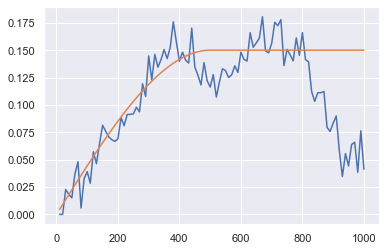

In [18]:
# Manual fitting for Cat. 0
rang=500
sill=0.15
nugget=0
gamma_h0= sph_var(lag_dist,rang,sill,nugget) 
plt.plot(lag_dist,EDVar0)
plt.plot(lag_dist,gamma_h0) # Fitted function

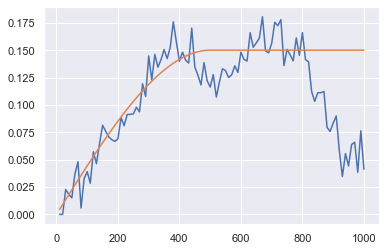

In [19]:
# Manual fitting for Cat. 1
rang=500
sill=0.15
nugget=0
gamma_h1= sph_var(lag_dist,rang,sill,nugget)
plt.plot(lag_dist,EDVar1)
plt.plot(lag_dist,gamma_h1) # Fitted function

In [20]:
# Total amount of cells and creating the dummy last bin

bins_point=np.arange(1,Nx*Ny+2,1)
hist=np.histogram(loc,bins=bins_point)
counts=hist[0]
grid_num=hist[1]
counts

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [21]:
# Excluding the last dummy cell

grid_num=grid_num[:-1]
grid_num

array([1.000e+00, 2.000e+00, 3.000e+00, ..., 9.998e+03, 9.999e+03,
       1.000e+04])

In [22]:
unknown_grids=grid_num[counts==0] # cells where the count from the histogram is zero
unknown_grids

array([1.000e+00, 2.000e+00, 3.000e+00, ..., 9.998e+03, 9.999e+03,
       1.000e+04])

In [23]:
P0_mat[:,0].shape

(368, 1)

In [24]:
prob0=np.zeros([int(Nx),int(Ny)])
prob1=np.zeros([int(Nx),int(Ny)])

for g in range(0,len(grid_num)):
    index=np.argwhere(loc==grid_num[g])
    ny=np.ceil(grid_num[g]/Nx) # This is equivalent to iy. Folllwing formula of loc above
    nx=(grid_num[g]-(ny-1)*Nx) # This is equivalent to ix in the formula of loc above
    if index.size !=0: # To avoid division by zero, If the index is different than zero
        prob0[int(ny)-1,int(nx)-1]=np.sum(P0_mat[index[:,0],0])/index.shape[0]
        prob1[int(ny)-1,int(nx)-1]=np.sum(P1_mat[index[:,0],0])/index.shape[0]
        
        if prob0[int(ny)-1,int(nx)-1] <0.5:
            prob0[int(ny)-1,int(nx)-1]=0
        else:
            prob0[int(ny)-1,int(nx)-1]=1
            
        if prob1[int(ny)-1,int(nx)-1] <=0.5:
            prob1[int(ny)-1,int(nx)-1]=0
        else:
            prob1[int(ny)-1,int(nx)-1]=1
            
        
prob0, prob1

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [25]:
def kriging(unknown_grids, Nx,grid_dim_x,grid_dim_y,dist,rang,sill,nugget):
    
    for ug in range(0,len(unknown_grids)):
        ny=np.ceil(unknown_grids[ug]/Nx) 
        nx=(unknown_grids[ug]-(ny-1)*Nx)
        x_coord=((nx-1)*grid_dim_x+nx*grid_dim_x)/2 
        y_coord=((ny-1)*grid_dim_y+ny*grid_dim_y)/2

        dist_uk_k=np.sqrt(np.power(X-x_coord,2)+np.power(Y-y_coord,2))

        points_within_circle=np.argwhere(dist_uk_k<100)
        ones_vec=np.asmatrix(np.ones(points_within_circle.shape[0]))
        X_known=X[points_within_circle[:,0]]*ones_vec
        Y_known=Y[points_within_circle[:,0]]*ones_vec
        dist=np.sqrt(np.power(X_known-X_known.T,2)+np.power(Y_known-Y_known.T,2))
        dist_uk_wr=dist_uk_k[points_within_circle[:,0]]

        gamma_known=sph_var(dist,rang,sill,nugget)
        COV_known=(nugget+sill)-gamma_known

        gamma_unknown=sph_var(dist_uk_wr,rang,sill,nugget)
        COV_unknown=(nugget+sill)-gamma_unknown
        lamb=np.linalg.inv(COV_known)*COV_unknown

        prob0[int(ny)-1,int(nx)-1]=sum(np.dot(lamb.T,P0[points_within_circle[:,0]]))+np.dot(1-sum(lamb),pk0)
        prob1[int(ny)-1,int(nx)-1]=sum(np.dot(lamb.T,P1[points_within_circle[:,0]]))+np.dot(1-sum(lamb),pk1)

        if prob0[int(ny)-1,int(nx)-1] <0:
            prob0[int(ny)-1,int(nx)-1]=0        
        if prob0[int(ny)-1,int(nx)-1] >1:
            prob0[int(ny)-1,int(nx)-1]=1

        if prob1[int(ny)-1,int(nx)-1] <0:
            prob1[int(ny)-1,int(nx)-1]=0
        if prob0[int(ny)-1,int(nx)-1] >1:
            prob1[int(ny)-1,int(nx)-1]=1

    prob0,prob1

In [26]:
kriging(unknown_grids, Nx,grid_dim_x,grid_dim_y,dist,rang,sill,nugget)

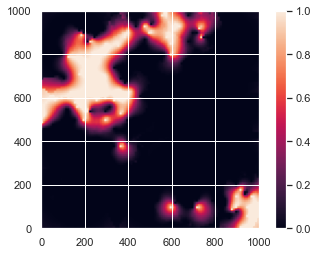

In [27]:
plt.imshow(prob1,extent=[0,length_x,length_y,0])
plt.gca().invert_yaxis()
plt.clim(0, 1)
plt.colorbar()

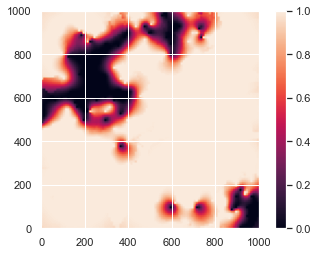

In [28]:
plt.imshow(prob0,extent=[0,length_x,length_y,0])
plt.gca().invert_yaxis()
plt.clim(0, 1)
plt.colorbar()